David Stern
IS 620 Final Project

In this project, I examine 2016 election data based on current filings with the Federal Election Commission (FEC). This FEC provides data on contributions to candidates for the House, Senate, and Presidential races on its website here: http://www.fec.gov/finance/disclosure/ftpdet.shtml. In the graphs below, we will explore only the data on contributions to candidates from committees, which are broadly defined to include, “federal political action committees and party committees, campaign committees for presidential, house and senate candidates, as
well as groups or organizations who are spending money for or against candidates for federal office.” The FEC provides this data in structure txt files, one each for the contributions (edges) and the committees and candidates (nodes). 

The following are data dictionaries provided by the FEC to help identify which data is important to our analysis: 

Committees Dictionary: http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml
Candidates Dictionary: http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml
Contributions Dictionary: http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionstoCandidates.shtml

(Downloaded on December 9, 2015)


In [2]:
import math
import csv
import urllib2
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pylab as plt
%matplotlib inline

First we will load the candidate and committe nodes from the two text files. These files were downloaded from the FEC website and uploaded to my Github repo on December 9. We first drop the columns that are not of interest (e.g. the postal address for the candidates' campaign offices) and then replace the abbreviations in the "seat status" and "office" with the full name for each.

In [3]:
candidate_url = 'https://raw.githubusercontent.com/dstern04/MSDA-Work/master/IS620/Final%20Project/cn.txt'
candidate_response = urllib2.urlopen(candidate_url)
candidates = pd.read_csv(candidate_response,sep='|',header=None)
candidates = candidates.drop(candidates.columns[[8,10,11,12,13,14]], axis=1)
candidates.columns = ['candidate_id','candidate_name','party',
                      'candidate_elected','state','office','district',
                      'seat_status','principal_committee']
candidates['seat_status'] = candidates['seat_status'].replace({'C': 'Challenger',
                                                               'I':'Incumbent',
                                                               'O':'Open Seat'},regex=True)
candidates['office'] = candidates['office'].replace({'H': 'House','S':'Senate',
                                                     'P':'President'},regex=True)
candidates.head(5)

,candidate_id,candidate_name,party,candidate_elected,state,office,district,seat_status,principal_committee
0,H0AK00097,"COX, JOHN R.",REP,2014,AK,House,0,Challenger,C00525261
1,H0AL02087,"ROBY, MARTHA",REP,2016,AL,House,2,Incumbent,C00462143
2,H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,House,2,Challenger,NaN
3,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,House,5,Challenger,C00239038
4,H0AL05163,"BROOKS, MO",REP,2016,AL,House,5,Incumbent,C00464149


Next, we do the same for the committee nodes. We excise unwanted and poorly reported data and then replace the abbreviations.

In [205]:
committee_url = 'https://raw.githubusercontent.com/dstern04/MSDA-Work/master/IS620/Final%20Project/cm.txt'
committee_response = urllib2.urlopen(committee_url)
committees = pd.read_csv(committee_response,sep='|',header=None)
committees = committees.drop(committees.columns[[2,3,4,5,6,7,10,11,13,14]], axis=1) 
committees.columns = ['committee_id','committee_name','committee_designation',
                      'committee_type','interest_group_category']

committees['committee_designation'] = committees['committee_designation'].replace(
    {'A': 'authorized by candidate','B':'lobbyist pac','D':'leadership pac','J':'joint fundraiser',
     'P':'principal campaign committee','U':'unauthorized'},regex=True)
committees['interest_group_category'] = committees['interest_group_category'].replace(
    {'C': 'corporation','L':'labor organization','M':'membership organization','T':'trade association',
     'V':'cooperative','W':'corp. w/o capital stock'},regex=True)
committees.head(5)

,committee_id,committee_name,committee_designation,committee_type,interest_group_category
0,C00000059,HALLMARK CARDS PAC,unauthorized,Q,corporation
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,lobbyist pac,Q,membership organization
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,unauthorized,N,labor organization
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,unauthorized,Q,trade association
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,unauthorized,Q,membership organization


Load Edges:

Now we load the edge data from the contributions from committees file. Since this represents edges, we excise every column except for the unique keys for candidates and committees, as well as the entity type and the amount of the contribution.

In [20]:
edge_url = 'https://raw.githubusercontent.com/dstern04/MSDA-Work/master/IS620/Final%20Project/itpas2.txt'
edge_response = urllib2.urlopen(edge_url)
links = pd.read_csv(edge_response,sep='|',header=None)
links = links.drop(links.columns[[1,2,3,4,5,7,8,9,10,11,12,13,15,17,18,19,20,21]], axis=1) 
links.columns = ['committee_id','entity_type','amount','candidate_id']
links.head(5)

,committee_id,entity_type,amount,candidate_id
0,C00411116,COM,1000,H0CA27085
1,C00411116,COM,2000,H6CA46033
2,C00411116,COM,1000,S2NE00094
3,C00411116,COM,2000,S0CA00199
4,C00411116,COM,1000,H4AZ07043


Finally, we use SQL-like merges to combine these three dataframes into one working dataframe that has all information for each contribution, including the candidate and committee names, which will make our graphed networks more readable.

In [21]:
combined = pd.merge(links, candidates, on='candidate_id', how ='inner')
combined = pd.merge(combined, committees, on='committee_id', how ='inner')
combined.head(2)

,committee_id,entity_type,amount,candidate_id,candidate_name,party,candidate_elected,state,office,district,seat_status,principal_committee,committee_name,committee_designation,committee_type,interest_group_category
0,C00411116,COM,1000,H0CA27085,"SCHIFF, ADAM",DEM,2016,CA,House,28,Incumbent,C00343871,SPACE EXPLORATION TECHNOLOGIES CORP. PAC,lobbyist pac,Q,corporation
1,C00411116,COM,1000,H0CA27085,"SCHIFF, ADAM",DEM,2016,CA,House,28,Incumbent,C00343871,SPACE EXPLORATION TECHNOLOGIES CORP. PAC,lobbyist pac,Q,corporation


From here, we can create graph objects from all of the edges in the 'combined' dataframe. For these, I modified the code in Chapter 5 in "Social Network Analysis for Startups" to create lists of candidates and committees and then project a bipartite graph on either of the nodes in order to visualize an affiliation network.

In [191]:
G = nx.Graph()
allComs = []
allPols = []
for index, row in combined.T.iteritems():
    if row['candidate_name'] not in allPols:
        allPols.append(row['candidate_name'])
    if row['committee_name'] not in allComs:
        allComs.append(row['committee_name'])
    G.add_edge(row['candidate_name'],row['committee_name']) # weight=int(row['amount'])

In [195]:
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

This trim_edges function uses the island method to narrow the network by cluster size. For each of the graphs below, we can use the trim_edges function in order to discard edge relationships under a certain weight. Viewing a histogram of the weights helps us determine which weight to choose to discard the less consequential edge relatonships. We will generally discard 80%, setting the cut-off at the two right-most bins.

(array([  6.05563000e+05,   3.07491000e+05,   1.11934000e+05,
          1.05974000e+05,   5.35710000e+04,   2.99940000e+04,
          1.24340000e+04,   4.22900000e+03,   7.27000000e+02,
          7.90000000e+01]),
 array([ 0.        ,  0.58464388,  1.16928776,  1.75393163,  2.33857551,
         2.92321939,  3.50786327,  4.09250714,  4.67715102,  5.2617949 ,
         5.84643878]),
 <a list of 10 Patch objects>)

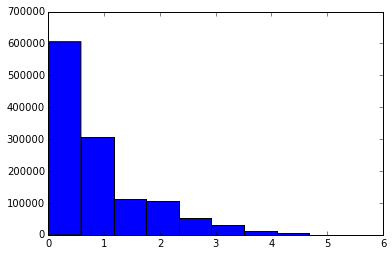

In [196]:
pacnet=bi.weighted_projected_graph(G, allComs, ratio=False)
weights=[math.log(edata['weight']) for f,t,edata in pacnet.edges(data=True)]
plt.hist(weights)

This graph below shows us the most connected committees. There seems to be a high-degree of embeddedness between defense contractors and a high-degree of betweenness-centrality for the National Association of Realtors PAC.

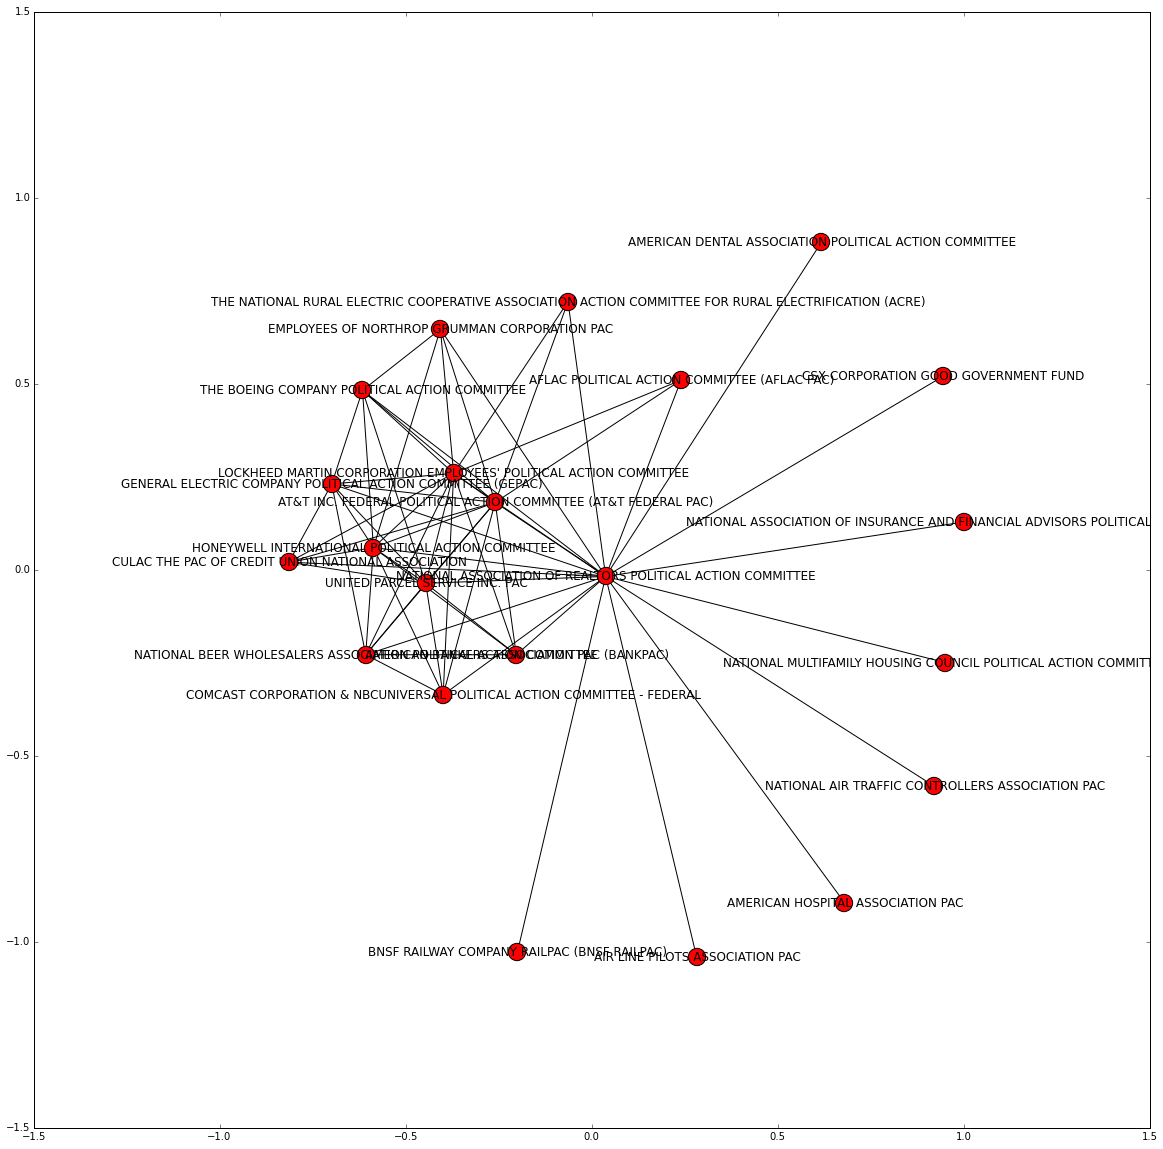

In [194]:
pols2 = trim_edges(pacnet, weight=math.exp(5.3))
plt.figure(figsize = (20,20))
weights2 = [edata['weight'] for f,t,edata in pols2.edges(data=True)]
nx.draw_networkx(pols2)

In the graph below, I projected the edge data on all politicians and trimmed the network to include the 12 nodes with the heighest weights. The profile of the politicans is interesting, as it only includes congressmen, not presidential candidates. All but four of the nodes in the graph are Republican Senators with a variety of powerful committee assignments. Two of the nodes - Kevin McCarthy and Patrick Tiberi - similarly hold powerful positions in the House. (McCarthy is the current Majority Leader and Tiberi a senior member of the Ways and Means committee.) The two Democrats in the graph - Chuck Schumer and Patty Murray - have both chaired the Democratic Senatorial Campaign Committee. Murray has also chaired the Senate's Budget Committee. This small network shows us that the most connected politicans are those that serve or have served as leaders of various commmittees with powerful financial roles in politics and campaign cycles. Republican Sen. Rob Portman seems to be the most connected in the network.

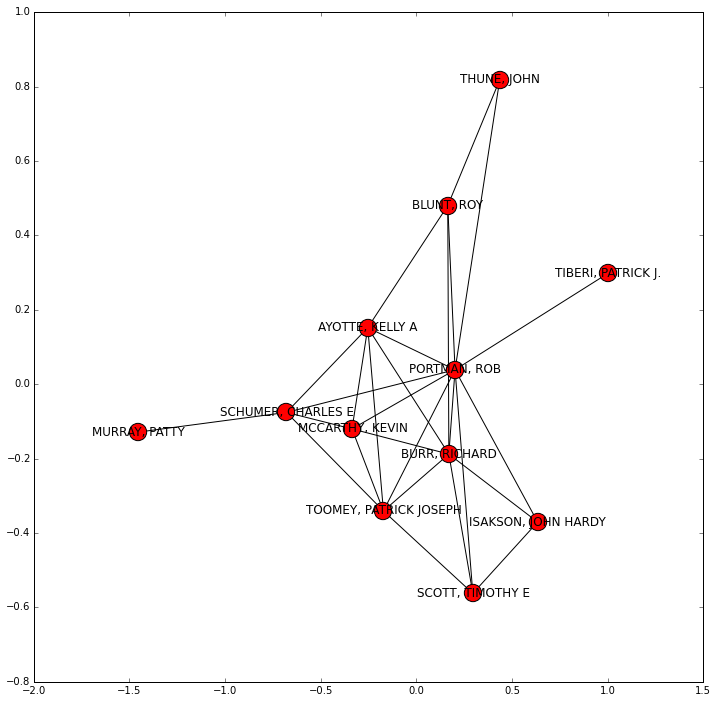

In [70]:
cannet = bi.weighted_projected_graph(G, allPols, ratio=False)  
cannet_trim = trim_edges(cannet, weight=190)
weights = [edata['weight'] for f,t,edata in cannet_trim.edges(data=True)] 
plt.figure(figsize=(12,12))
nx.draw_networkx(cannet_trim)

The following two commands will return all possible values in the committee designation and interest group category columns. We can use these values to subset our dataframe and look at new networks.

In [197]:
combined['committee_designation'].unique()

array(['lobbyist pac', 'unauthorized', 'principal campaign committee',
       'leadership pac', 'joint fundraiser', 'authorized by candidate'], dtype=object)

In [188]:
combined['interest_group_category'].unique()

array(['corporation', 'membership organization', 'labor organization',
       'trade association', 'corp. w/o capital stock', nan, 'cooperative'], dtype=object)

Here we narrow the edges to only include contributions from committees defined as corporations. It also demonstrates a highly connected network of defense contractors and telecommunications companies.

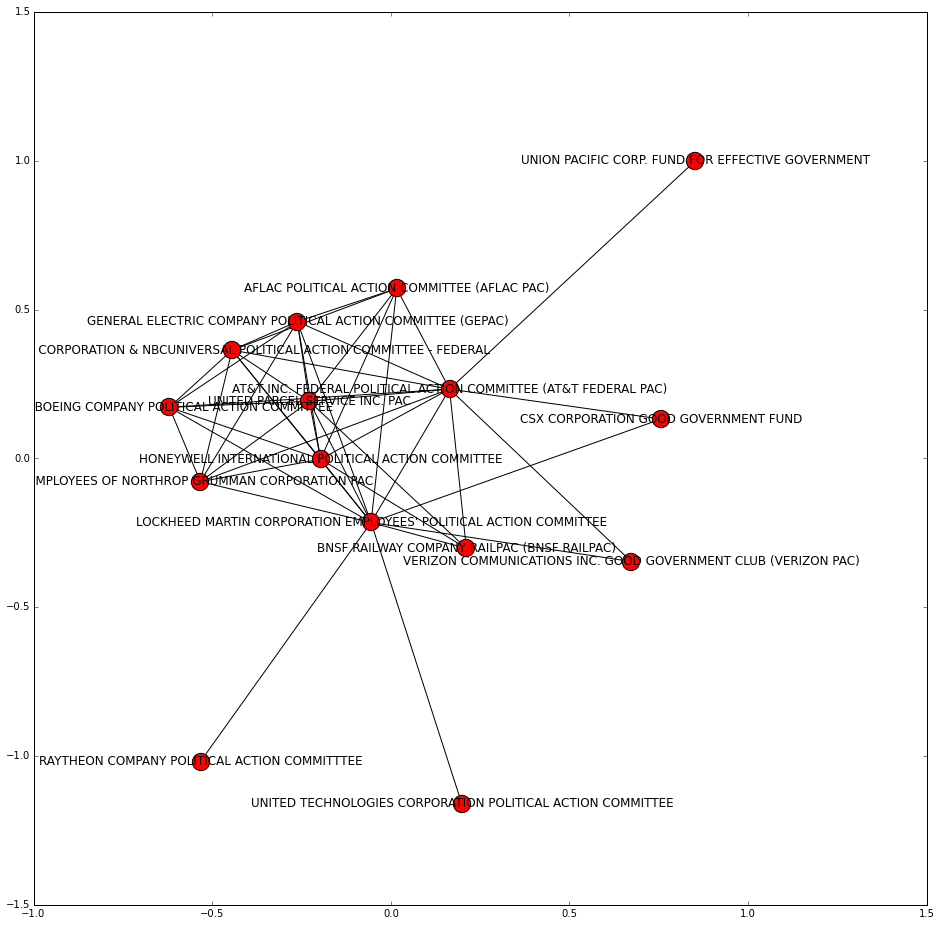

In [200]:
corpContributions = combined[combined.interest_group_category == 'corporation']
G3 = nx.Graph()
allComs3 = []
allPols3 = []
for index, row in corpContributions.T.iteritems():
    if row['candidate_name'] not in allPols3:
        allPols3.append(row['candidate_name'])
    if row['committee_name'] not in allComs3:
        allComs3.append(row['committee_name'])
    G3.add_edge(row['candidate_name'],row['committee_name'])
cannet3 = bi.weighted_projected_graph(G3, allComs3, ratio=False)  
weights3 = [edata['weight'] for f,t,edata in cannet3.edges(data=True)] 
cannet_trim3 = trim_edges(cannet3, weight=172) 
plt.figure(figsize=(16,16))
nx.draw_networkx(cannet_trim3)

Now we will look specifically at contribution data for the 2016 Presidential election. The structure of the network is interesting in that Hillary Clinton seems to be closely linked to a number of establishment Republicans. This indicates that committees that donated to Hillary Clinton also donated to a number of Repepublican candidates. It is also interesting that Jeb Bush is only connected to Secretary Clinton, and doesn't seem to be linked to any of the other candidates.

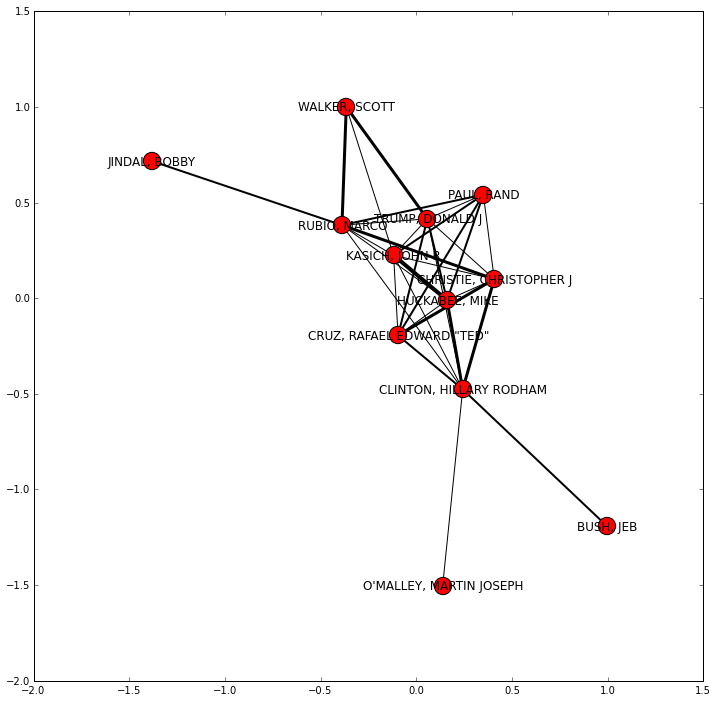

In [171]:
pres_primary = combined[(combined.office == 'President') & (combined.candidate_elected == 2016)]
G4 = nx.Graph()
allComs4 = []
allPols4 = []
for index, row in pres_primary.T.iteritems():
    if row['candidate_name'] not in allPols4:
        allPols4.append(row['candidate_name'])
    if row['committee_name'] not in allComs4:
        allComs4.append(row['committee_name'])
    G4.add_edge(row['candidate_name'],row['committee_name'])
cannet4 = bi.weighted_projected_graph(G4, allPols4, ratio=False)  
weights4 = [edata['weight'] for f,t,edata in cannet4.edges(data=True)] 
cannet_trim4 = trim_edges(cannet4, weight=1.6) 
plt.figure(figsize=(12,12))
nx.draw_networkx(cannet_trim4,width=weights4)

To get a list of contributors to a particular candidate for President, we need only filter the pres_primary dataframe and reduce it to a list of unique edges. Here is a list of all committees that have contributed to Rubio.

In [199]:
pres_primary[pres_primary.candidate_name == 'RUBIO, MARCO'].committee_name.unique()

array(['TWENTY-FIRST CENTURY FOX, INC. PAC (FOX PAC)',
       'FOLEY & LARDNER POLITICAL FUND, INC.',
       'MCDONALDS CORPORATION POLITICAL ACTION COMMITTEE',
       'THE COCA-COLA COMPANY NONPARTISAN COMMITTEE FOR GOOD GOVERNMENT',
       'NATIONAL CABLE AND TELECOMMUNICATIONS ASSOCIATION POLITICAL ACTION COMMITTEE (NCTA PAC)',
       'THE HOME DEPOT INC. POLITICAL ACTION COMMITTEE',
       'FACEBOOK INC. PAC',
       'T-MOBILE USA, INC.  POLITICAL ACTION COMMITTEE (T-PAC)',
       'AMERISOURCEBERGEN CORPORATION POLITICAL ACTION COMMITTEE (ABC PAC)',
       'WELLS FARGO AND COMPANY EMPLOYEE PAC (AKA WELLS FARGO EMPLOYEE PAC)',
       'MICROSOFT CORPORATION POLITICAL ACTION COMMITTEE',
       'UNITED SERVICES AUTOMOBILE ASSOCIATION EMPLOYEE PAC - USAA EMPLOYEE PAC',
       'KPMG PARTNERS/PRINCIPALS AND EMPLOYEES PAC',
       'KOCH INDUSTRIES INC POLITICAL ACTION COMMITTEE (KOCHPAC)',
       'VALERO ENERGY CORPORATION POLITICAL ACTION COMMITTEE',
       'FMR LLC POLITICAL ACTION COMMI